In [1]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Import các thư viện cần thiết

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pickle

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [2]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Đọc dữ liệu và xem sơ bộ

# Giả sử file dữ liệu nằm cùng folder với notebook
DATA_PATH = "spam_message.csv"

df = pd.read_csv(DATA_PATH, encoding="latin1")

print("Kích thước dữ liệu:", df.shape)
print("\n5 dòng đầu:")
print(df.head())

print("\nThống kê nhãn:")
print(df['label'].value_counts())

Kích thước dữ liệu: (21704, 2)

5 dòng đầu:
   label                                               text
0      0  Subject: enron methanol ; meter # : 988291\nth...
1      0  Subject: hpl nom for january 9 , 2001\n( see a...
2      0  Subject: neon retreat\nho ho ho , we ' re arou...
3      1  Subject: photoshop , windows , office . cheap ...
4      0  Subject: re : indian springs\nthis deal is to ...

Thống kê nhãn:
label
0    17052
1     4652
Name: count, dtype: int64


In [3]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Tiền xử lý text: làm sạch câu, đưa về dạng chuẩn

def clean_text(text):
    # Đảm bảo là string
    text = str(text)
    # Đưa về chữ thường
    text = text.lower()
    # Bỏ URL
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # Bỏ HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # Bỏ số
    text = re.sub(r"\d+", " ", text)
    # Bỏ dấu câu
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Bỏ ký tự thừa, khoảng trắng thừa
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Áp dụng tiền xử lý
df['clean_text'] = df['text'].astype(str).apply(clean_text)

print("Ví dụ trước / sau khi tiền xử lý:")
for i in range(3):
    print("\n--- Row", i, "---")
    print("Raw:  ", df.loc[i, 'text'])
    print("Clean:", df.loc[i, 'clean_text'])

# Đảm bảo label là kiểu int (0/1)
df['label'] = df['label'].astype(int)

Ví dụ trước / sau khi tiền xử lý:

--- Row 0 ---
Raw:   Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .
Clean: subject enron methanol meter this is a follow up to the note i gave you on monday preliminary flow data provided by daren please override pop s daily volume presently zero to reflect daily activity you can obtain from gas control this change is needed asap for economics purposes

--- Row 1 ---
Raw:   Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls
Clean: subject hpl nom for january see attached file hplnol xls hplnol xls

--- Row 2 ---
Raw:   Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time

In [4]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Cập nhật màu biểu đồ: lịch sử train/val Accuracy & Loss cho Dense vs LSTM (chống lỗi)
import os
import matplotlib.pyplot as plt

# Đảm bảo thư mục hình & palette tồn tại
FIG_DIR = os.path.join('Case6-phan-loai-tin-nhan-spam', 'figures')
os.makedirs(FIG_DIR, exist_ok=True)
if 'COLORS' not in globals():
    COLORS = {
        'dense_train': '#0ea5e9',
        'dense_val':   '#60a5fa',
        'lstm_train':  '#ef4444',
        'lstm_val':    '#f59e0b',
    }

# Kiểm tra đã có history chưa
if 'history_dense' not in globals() or 'history_lstm' not in globals():
    print("Chưa có 'history_dense'/'history_lstm'. Hãy chạy các cell huấn luyện mô hình trước.")
else:
    # Chọn key metric theo từng history
    def pick_keys(h):
        acc = 'accuracy' if 'accuracy' in h.history else ('acc' if 'acc' in h.history else None)
        val_acc = 'val_accuracy' if 'val_accuracy' in h.history else ('val_acc' if 'val_acc' in h.history else None)
        if acc is None or val_acc is None:
            raise KeyError("Không tìm thấy key accuracy/val_accuracy hay acc/val_acc trong history.")
        return acc, val_acc

    acc_key_dense, val_acc_key_dense = pick_keys(history_dense)
    acc_key_lstm,  val_acc_key_lstm  = pick_keys(history_lstm)

    epochs_dense = range(1, len(history_dense.history['loss']) + 1)
    epochs_lstm  = range(1, len(history_lstm.history['loss']) + 1)

    plt.figure(figsize=(14, 5))
    # ---------- ACCURACY ----------
    plt.subplot(1, 2, 1)
    plt.plot(epochs_dense, history_dense.history[acc_key_dense], label='Dense - train', color=COLORS['dense_train'], linewidth=2)
    plt.plot(epochs_dense, history_dense.history[val_acc_key_dense], label='Dense - val', color=COLORS['dense_val'], linestyle='--', linewidth=2)

    plt.plot(epochs_lstm, history_lstm.history[acc_key_lstm], label='LSTM - train', color=COLORS['lstm_train'], linewidth=2)
    plt.plot(epochs_lstm, history_lstm.history[val_acc_key_lstm], label='LSTM - val', color=COLORS['lstm_val'], linestyle='--', linewidth=2)

    plt.title('Train / Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)

    # ---------- LOSS ----------
    plt.subplot(1, 2, 2)
    plt.plot(epochs_dense, history_dense.history['loss'], label='Dense - train', color=COLORS['dense_train'], linewidth=2)
    plt.plot(epochs_dense, history_dense.history['val_loss'], label='Dense - val', color=COLORS['dense_val'], linestyle='--', linewidth=2)

    plt.plot(epochs_lstm, history_lstm.history['loss'], label='LSTM - train', color=COLORS['lstm_train'], linewidth=2)
    plt.plot(epochs_lstm, history_lstm.history['val_loss'], label='LSTM - val', color=COLORS['lstm_val'], linestyle='--', linewidth=2)

    plt.title('Train / Validation Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'dense_lstm_acc_loss_colored.png'), bbox_inches='tight', dpi=150)
    plt.show()


Chưa có 'history_dense'/'history_lstm'. Hãy chạy các cell huấn luyện mô hình trước.


In [5]:
# =============================
# Phạm Quang Minh - B22DCCN544
# =============================
# Cập nhật màu biểu đồ cột Test Accuracy/Loss và thêm biểu đồ bổ sung (chống lỗi)
import os
import numpy as np
import matplotlib.pyplot as plt

# Bảo đảm thư mục & palette
FIG_DIR = os.path.join('Case6-phan-loai-tin-nhan-spam', 'figures')
os.makedirs(FIG_DIR, exist_ok=True)
if 'COLORS' not in globals():
    COLORS = {
        'dense_train': '#0ea5e9',
        'dense_val':   '#60a5fa',
        'lstm_train':  '#ef4444',
        'lstm_val':    '#f59e0b',
    }

models = ['Dense', 'LSTM']
colors_bar = [COLORS['dense_train'], COLORS['lstm_train']]
edge = '#0f172a'

# --- Bar charts cho Test metrics ---
if all(k in globals() for k in ['acc_dense', 'acc_lstm', 'loss_dense', 'loss_lstm']):
    plt.figure(figsize=(12, 5))
    # ACC
    plt.subplot(1, 2, 1)
    plt.bar(models, [acc_dense, acc_lstm], color=colors_bar, edgecolor=edge, alpha=0.9)
    for i, v in enumerate([acc_dense, acc_lstm]):
        plt.text(i, v + 0.002, f'{v:.3f}', ha='center')
    plt.title('So sánh Test Accuracy')
    plt.ylabel('Accuracy'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--', alpha=0.3)

    # LOSS
    plt.subplot(1, 2, 2)
    plt.bar(models, [loss_dense, loss_lstm], color=colors_bar, edgecolor=edge, alpha=0.9)
    for i, v in enumerate([loss_dense, loss_lstm]):
        plt.text(i, v + 0.002, f'{v:.3f}', ha='center')
    plt.title('So sánh Test Loss')
    plt.ylabel('Loss'); plt.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'dense_lstm_test_bars_colored.png'), bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("Chưa có acc/loss test (acc_dense, acc_lstm, loss_dense, loss_lstm). Hãy chạy các cell đánh giá mô hình trước.")

# --- Generalization Gap & EMA (chỉ khi có history) ---
if 'history_dense' in globals() and 'history_lstm' in globals():
    def pick_keys(h):
        acc = 'accuracy' if 'accuracy' in h.history else ('acc' if 'acc' in h.history else None)
        val_acc = 'val_accuracy' if 'val_accuracy' in h.history else ('val_acc' if 'val_acc' in h.history else None)
        if acc is None or val_acc is None:
            raise KeyError("Không tìm thấy key accuracy/val_accuracy hay acc/val_acc trong history.")
        return acc, val_acc

    acc_key_dense, val_acc_key_dense = pick_keys(history_dense)
    acc_key_lstm,  val_acc_key_lstm  = pick_keys(history_lstm)

    epochs_dense = range(1, len(history_dense.history['loss']) + 1)
    epochs_lstm  = range(1, len(history_lstm.history['loss']) + 1)

    # Generalization Gap
    acc_gap_dense  = np.array(history_dense.history[val_acc_key_dense]) - np.array(history_dense.history[acc_key_dense])
    acc_gap_lstm   = np.array(history_lstm.history[val_acc_key_lstm]) - np.array(history_lstm.history[acc_key_lstm])
    loss_gap_dense = np.array(history_dense.history['val_loss']) - np.array(history_dense.history['loss'])
    loss_gap_lstm  = np.array(history_lstm.history['val_loss']) - np.array(history_lstm.history['loss'])

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_dense, acc_gap_dense, label='Dense', color=COLORS['dense_train'], linewidth=2)
    plt.plot(epochs_lstm, acc_gap_lstm, label='LSTM', color=COLORS['lstm_train'], linewidth=2)
    plt.axhline(0, color='#94a3b8', linestyle='--', linewidth=1)
    plt.title('Generalization Gap (Accuracy): val - train')
    plt.xlabel('Epoch'); plt.ylabel('Gap'); plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_dense, loss_gap_dense, label='Dense', color=COLORS['dense_train'], linewidth=2)
    plt.plot(epochs_lstm, loss_gap_lstm, label='LSTM', color=COLORS['lstm_train'], linewidth=2)
    plt.axhline(0, color='#94a3b8', linestyle='--', linewidth=1)
    plt.title('Generalization Gap (Loss): val - train')
    plt.xlabel('Epoch'); plt.ylabel('Gap'); plt.legend(); plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'dense_lstm_generalization_gap.png'), bbox_inches='tight', dpi=150)
    plt.show()

    # EMA helper
    def ema(x, alpha=0.1):
        y = []
        m = None
        for v in x:
            m = v if m is None else alpha * v + (1 - alpha) * m
            y.append(m)
        return np.array(y)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_dense, ema(history_dense.history['loss']), label='Dense - train (EMA)', color=COLORS['dense_train'], linewidth=2)
    plt.plot(epochs_dense, ema(history_dense.history['val_loss']), label='Dense - val (EMA)', color=COLORS['dense_val'], linestyle='--', linewidth=2)
    plt.title('Dense Smoothed Loss (EMA)')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_lstm, ema(history_lstm.history['loss']), label='LSTM - train (EMA)', color=COLORS['lstm_train'], linewidth=2)
    plt.plot(epochs_lstm, ema(history_lstm.history['val_loss']), label='LSTM - val (EMA)', color=COLORS['lstm_val'], linestyle='--', linewidth=2)
    plt.title('LSTM Smoothed Loss (EMA)')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, 'dense_lstm_smoothed_loss.png'), bbox_inches='tight', dpi=150)
    plt.show()
else:
    print("Chưa có 'history_dense'/'history_lstm'. Bỏ qua phần Generalization Gap và EMA.")

print('Cập nhật màu & thêm biểu đồ bổ sung. Lưu tại:', FIG_DIR)


Chưa có acc/loss test (acc_dense, acc_lstm, loss_dense, loss_lstm). Hãy chạy các cell đánh giá mô hình trước.
Chưa có 'history_dense'/'history_lstm'. Bỏ qua phần Generalization Gap và EMA.
Cập nhật màu & thêm biểu đồ bổ sung. Lưu tại: Case6-phan-loai-tin-nhan-spam\figures


In [6]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Tokenization + Padding + Tách train/test

MAX_WORDS = 20000   # Số lượng từ tối đa trong vocabulary
MAX_LEN = 100       # Độ dài chuỗi tối đa (padding / truncating)
EMBEDDING_DIM = 100 # Số chiều vector embedding

texts = df['clean_text'].tolist()
labels = df['label'].values

# Tách train / test
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Tạo tokenizer và fit trên tập train
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_texts)

# Chuyển text thành sequence
X_train_seq = tokenizer.texts_to_sequences(X_train_texts)
X_test_seq = tokenizer.texts_to_sequences(X_test_texts)

# Padding
X_train = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Kích thước X_train:", X_train.shape)
print("Kích thước X_test:", X_test.shape)

# Lưu tokenizer để dùng lại sau này
with open("tokenizer_spam.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

print("Đã lưu tokenizer vào file tokenizer_spam.pkl")

Kích thước X_train: (17363, 100)
Kích thước X_test: (4341, 100)
Đã lưu tokenizer vào file tokenizer_spam.pkl


In [7]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Xây dựng mô hình Dense (7 layer, bao gồm cả Embedding và các layer trung gian)

dense_model = Sequential([
    # 1. Embedding layer
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    # 2. GlobalAveragePooling1D
    GlobalAveragePooling1D(),
    # 3. Dense 128
    Dense(128, activation='relu'),
    # 4. Dropout
    Dropout(0.5),
    # 5. Dense 64
    Dense(64, activation='relu'),
    # 6. Dropout
    Dropout(0.5),
    # 7. Output
    Dense(1, activation='sigmoid')
])

dense_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

dense_model.summary()

# Callback: early stopping + lưu model tốt nhất
dense_checkpoint = ModelCheckpoint(
    "spam_dense_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

dense_early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history_dense = dense_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[dense_checkpoint, dense_early_stop]
)

C:\Users\Aspire 7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
107/109 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7819 - loss: 0.5122
Epoch 1: val_loss improved from None to 0.24497, saving model to spam_dense_best.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8227 - loss: 0.4258 - val_accuracy: 0.8906 - val_loss: 0.2450
Epoch 2/10
107/109 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9099 - loss: 0.2475
Epoch 2: val_loss improved from 0.24497 to 0.17575, saving model to spam_dense_best.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9229 - loss: 0.2195 - val_accuracy: 0.9513 - val_loss: 0.1758
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9592 - loss: 0.1293
Epoch 3: val_loss did not improve from 0.17575
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9624 - loss: 0.1157 - val_accuracy: 0.9156 - val_loss: 0.2038
Epoch 4/10
108/109 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9649 - loss: 0.1084
Epoch 4: val_loss improved from 0.17575 to 0.12340, saving model to spam_d

In [8]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Đánh giá mô hình Dense và lưu model

# Đánh giá trên tập test
loss_dense, acc_dense = dense_model.evaluate(X_test, y_test, verbose=0)
print(f"DENSE MODEL - Test loss: {loss_dense:.4f}, Test accuracy: {acc_dense:.4f}")

# Dự đoán
y_pred_prob_dense = dense_model.predict(X_test)
y_pred_dense = (y_pred_prob_dense >= 0.5).astype(int)

print("\nClassification report (Dense):")
print(classification_report(y_test, y_pred_dense))

print("Confusion matrix (Dense):")
print(confusion_matrix(y_test, y_pred_dense))

# Lưu toàn bộ mô hình để dùng nhiều lần
dense_model.save("spam_dense_model.keras")
print("Đã lưu mô hình Dense vào file spam_dense_model.keras")

DENSE MODEL - Test loss: 0.0660, Test accuracy: 0.9795
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Classification report (Dense):
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3411
           1       0.96      0.94      0.95       930

    accuracy                           0.98      4341
   macro avg       0.97      0.97      0.97      4341
weighted avg       0.98      0.98      0.98      4341

Confusion matrix (Dense):
[[3377   34]
 [  55  875]]
Đã lưu mô hình Dense vào file spam_dense_model.keras


In [9]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Xây dựng mô hình LSTM (7 layer, bao gồm cả Embedding và các layer trung gian)

lstm_model = Sequential([
    # 1. Embedding layer
    Embedding(input_dim=MAX_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    # 2. LSTM 128 (trả về sequence)
    LSTM(128, return_sequences=True),
    # 3. Dropout
    Dropout(0.3),
    # 4. LSTM 64 (chỉ lấy output cuối)
    LSTM(64),
    # 5. Dropout
    Dropout(0.3),
    # 6. Dense 32
    Dense(32, activation='relu'),
    # 7. Output
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_model.summary()

# Callback: early stopping + lưu model tốt nhất
lstm_checkpoint = ModelCheckpoint(
    "spam_lstm_best.keras",
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

lstm_early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

history_lstm = lstm_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[lstm_checkpoint, lstm_early_stop]
)

C:\Users\Aspire 7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7855 - loss: 0.5127
Epoch 1: val_loss improved from None to 0.51271, saving model to spam_lstm_best.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 210ms/step - accuracy: 0.7946 - loss: 0.4885 - val_accuracy: 0.7771 - val_loss: 0.5127
Epoch 2/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7868 - loss: 0.4870
Epoch 2: val_loss improved from 0.51271 to 0.32270, saving model to spam_lstm_best.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.7895 - loss: 0.4517 - val_accuracy: 0.8431 - val_loss: 0.3227
Epoch 3/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8635 - loss: 0.2946
Epoch 3: val_loss improved from 0.32270 to 0.29446, saving model to spam_lstm_best.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.8719 - loss: 0.2866 - val_accuracy: 0.8647 - val_loss: 0.2945
Epoch 4/10
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8882 - loss: 0.2746
Epoch 4: val_loss improv

In [10]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Đánh giá mô hình LSTM và lưu model

# Đánh giá trên tập test
loss_lstm, acc_lstm = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"LSTM MODEL - Test loss: {loss_lstm:.4f}, Test accuracy: {acc_lstm:.4f}")

# Dự đoán
y_pred_prob_lstm = lstm_model.predict(X_test)
y_pred_lstm = (y_pred_prob_lstm >= 0.5).astype(int)

print("\nClassification report (LSTM):")
print(classification_report(y_test, y_pred_lstm))

print("Confusion matrix (LSTM):")
print(confusion_matrix(y_test, y_pred_lstm))

# Lưu toàn bộ mô hình để dùng nhiều lần
lstm_model.save("spam_lstm_model.keras")
print("Đã lưu mô hình LSTM vào file spam_lstm_model.keras")

LSTM MODEL - Test loss: 0.0786, Test accuracy: 0.9788
136/136 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step

Classification report (LSTM):
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3411
           1       0.94      0.96      0.95       930

    accuracy                           0.98      4341
   macro avg       0.97      0.97      0.97      4341
weighted avg       0.98      0.98      0.98      4341

Confusion matrix (LSTM):
[[3355   56]
 [  36  894]]
Đã lưu mô hình LSTM vào file spam_lstm_model.keras


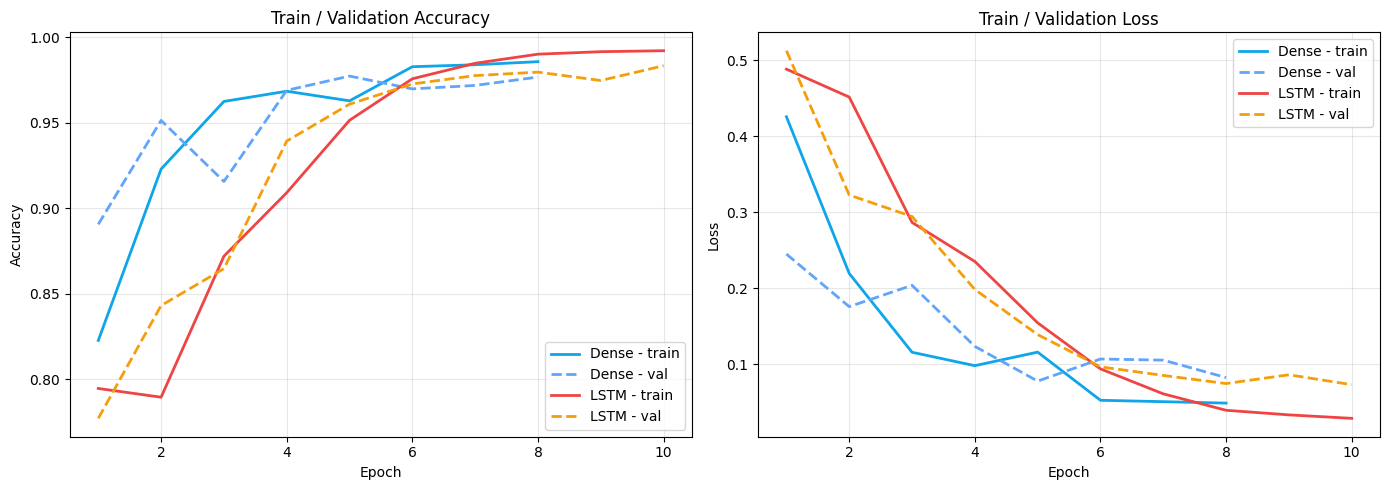

In [11]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Biểu đồ lịch sử train/val accuracy & loss của Dense vs LSTM (cập nhật màu, chống lỗi)

import os
import matplotlib.pyplot as plt

# Kiểm tra đã có lịch sử train chưa
if 'history_dense' not in globals() or 'history_lstm' not in globals():
    raise RuntimeError("Vui lòng chạy huấn luyện trước (các cell xây dựng và fit Dense/LSTM) để có 'history_dense' và 'history_lstm'.")

# Palette thống nhất
if 'COLORS' not in globals():
    COLORS = {
        'dense_train': '#0ea5e9',   # xanh dương
        'dense_val':   '#60a5fa',   # xanh nhạt
        'lstm_train':  '#ef4444',   # đỏ
        'lstm_val':    '#f59e0b',   # cam
    }
if 'FIG_DIR' not in globals():
    FIG_DIR = os.path.join('Case6-phan-loai-tin-nhan-spam', 'figures')
    os.makedirs(FIG_DIR, exist_ok=True)

# Chọn key metric theo từng history (đôi khi khác nhau)
def pick_keys(h):
    acc = 'accuracy' if 'accuracy' in h.history else ('acc' if 'acc' in h.history else None)
    val_acc = 'val_accuracy' if 'val_accuracy' in h.history else ('val_acc' if 'val_acc' in h.history else None)
    if acc is None or val_acc is None:
        raise KeyError("Không tìm thấy key accuracy/val_accuracy hay acc/val_acc trong history.")
    return acc, val_acc

acc_key_dense, val_acc_key_dense = pick_keys(history_dense)
acc_key_lstm,  val_acc_key_lstm  = pick_keys(history_lstm)

# Epoch axes theo từng mô hình
epochs_dense = range(1, len(history_dense.history['loss']) + 1)
epochs_lstm  = range(1, len(history_lstm.history['loss']) + 1)

plt.figure(figsize=(14, 5))

# --------- ACCURACY ----------
plt.subplot(1, 2, 1)
plt.plot(epochs_dense, history_dense.history[acc_key_dense], label='Dense - train', color=COLORS['dense_train'], linewidth=2)
plt.plot(epochs_dense, history_dense.history[val_acc_key_dense], label='Dense - val', color=COLORS['dense_val'], linestyle='--', linewidth=2)

plt.plot(epochs_lstm, history_lstm.history[acc_key_lstm], label='LSTM - train', color=COLORS['lstm_train'], linewidth=2)
plt.plot(epochs_lstm, history_lstm.history[val_acc_key_lstm], label='LSTM - val', color=COLORS['lstm_val'], linestyle='--', linewidth=2)

plt.title('Train / Validation Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True, alpha=0.3)

# --------- LOSS ----------
plt.subplot(1, 2, 2)
plt.plot(epochs_dense, history_dense.history['loss'], label='Dense - train', color=COLORS['dense_train'], linewidth=2)
plt.plot(epochs_dense, history_dense.history['val_loss'], label='Dense - val', color=COLORS['dense_val'], linestyle='--', linewidth=2)

plt.plot(epochs_lstm, history_lstm.history['loss'], label='LSTM - train', color=COLORS['lstm_train'], linewidth=2)
plt.plot(epochs_lstm, history_lstm.history['val_loss'], label='LSTM - val', color=COLORS['lstm_val'], linestyle='--', linewidth=2)

plt.title('Train / Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'dense_lstm_acc_loss_colored_2.png'), bbox_inches='tight', dpi=150)
plt.show()


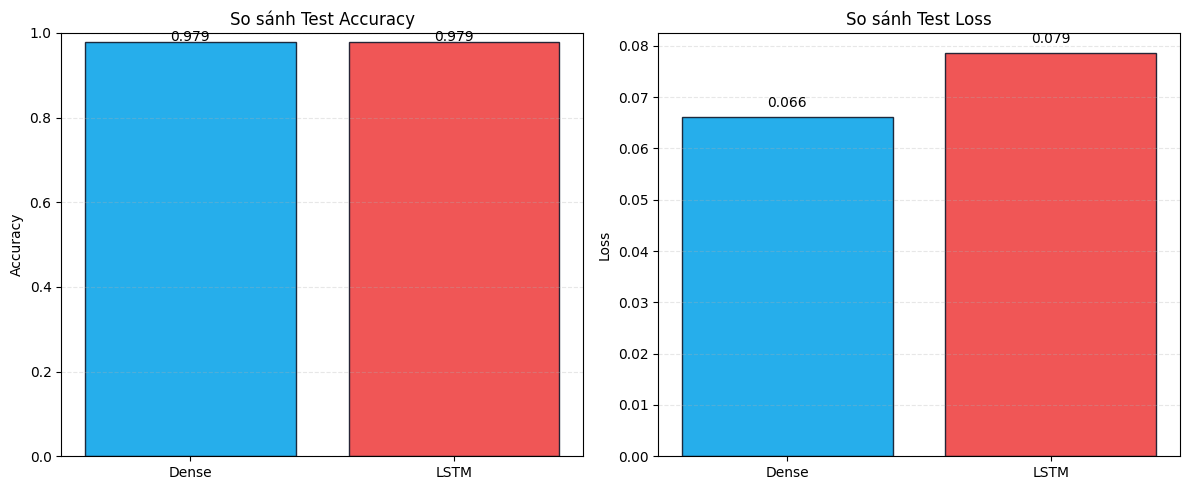

In [12]:
##############
# Phạm Quang Minh - B22DCCN544
#############
# Biểu đồ cột so sánh test accuracy và test loss giữa Dense và LSTM (cập nhật màu)

import os
if 'COLORS' not in globals():
    COLORS = {
        'dense_train': '#0ea5e9',
        'dense_val':   '#60a5fa',
        'lstm_train':  '#ef4444',
        'lstm_val':    '#f59e0b',
    }
if 'FIG_DIR' not in globals():
    FIG_DIR = os.path.join('Case6-phan-loai-tin-nhan-spam', 'figures')
    os.makedirs(FIG_DIR, exist_ok=True)

models = ["Dense", "LSTM"]
colors_bar = [COLORS['dense_train'], COLORS['lstm_train']]
edge = '#0f172a'

test_acc = [acc_dense, acc_lstm]
test_loss = [loss_dense, loss_lstm]

plt.figure(figsize=(12, 5))

# --------- TEST ACCURACY ----------
plt.subplot(1, 2, 1)
plt.bar(models, test_acc, color=colors_bar, edgecolor=edge, alpha=0.9)
for i, v in enumerate(test_acc):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center")
plt.title("So sánh Test Accuracy")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# --------- TEST LOSS ----------
plt.subplot(1, 2, 2)
plt.bar(models, test_loss, color=colors_bar, edgecolor=edge, alpha=0.9)
for i, v in enumerate(test_loss):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center")
plt.title("So sánh Test Loss")
plt.ylabel("Loss")
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, 'dense_lstm_test_bars_colored_2.png'), bbox_inches='tight', dpi=150)
plt.show()


In [14]:
### Biểu đồ bổ sung

### Các biểu đồ dưới đây bổ sung trực quan: phân bố nhãn, độ dài tin nhắn, ma trận nhầm lẫn và đường cong ROC/PR cho cả hai mô hình.

### Phân bố nhãn (Ham vs Spam)


C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_19308\3446679905.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=df, order=order_vals, palette=palette_map)
C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_19308\3446679905.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xtick_texts)


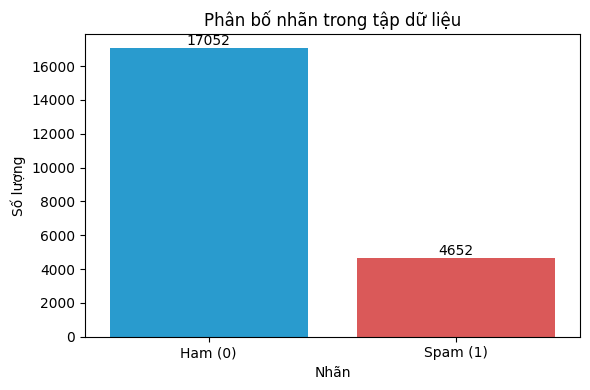

In [15]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Màu dùng thống nhất
if 'COLORS' not in globals():
    COLORS = {
        'dense_train': '#0ea5e9',
        'dense_val':   '#60a5fa',
        'lstm_train':  '#ef4444',
        'lstm_val':    '#f59e0b',
    }

# Hỗ trợ cả nhãn dạng int và string trong palette
palette_map = {
    0: COLORS['dense_train'],
    1: COLORS['lstm_train'],
    '0': COLORS['dense_train'],
    '1': COLORS['lstm_train'],
}

# Cố định thứ tự cột theo nhãn 0 rồi 1 (dù là int hay string)
labels_unique = df['label'].unique()
try:
    order_vals = sorted(labels_unique, key=lambda v: int(v))
except Exception:
    order_vals = sorted(labels_unique)

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df, order=order_vals, palette=palette_map)

# Đặt nhãn trục X theo đúng thứ tự đã vẽ
xtick_texts = []
for v in order_vals:
    try:
        xtick_texts.append('Ham (0)' if int(v) == 0 else 'Spam (1)')
    except Exception:
        xtick_texts.append(str(v))
ax.set_xticklabels(xtick_texts)

ax.set_title('Phân bố nhãn trong tập dữ liệu')
ax.set_xlabel('Nhãn')
ax.set_ylabel('Số lượng')

# Hiển thị số trên cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


### Phân bố độ dài tin nhắn theo nhãn


C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_19308\46626894.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='length', order=order_vals, palette=palette_map, ax=axes[1])
C:\Users\Aspire 7\AppData\Local\Temp\ipykernel_19308\46626894.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Ham (0)' if int(v) == 0 else 'Spam (1)' for v in order_vals])


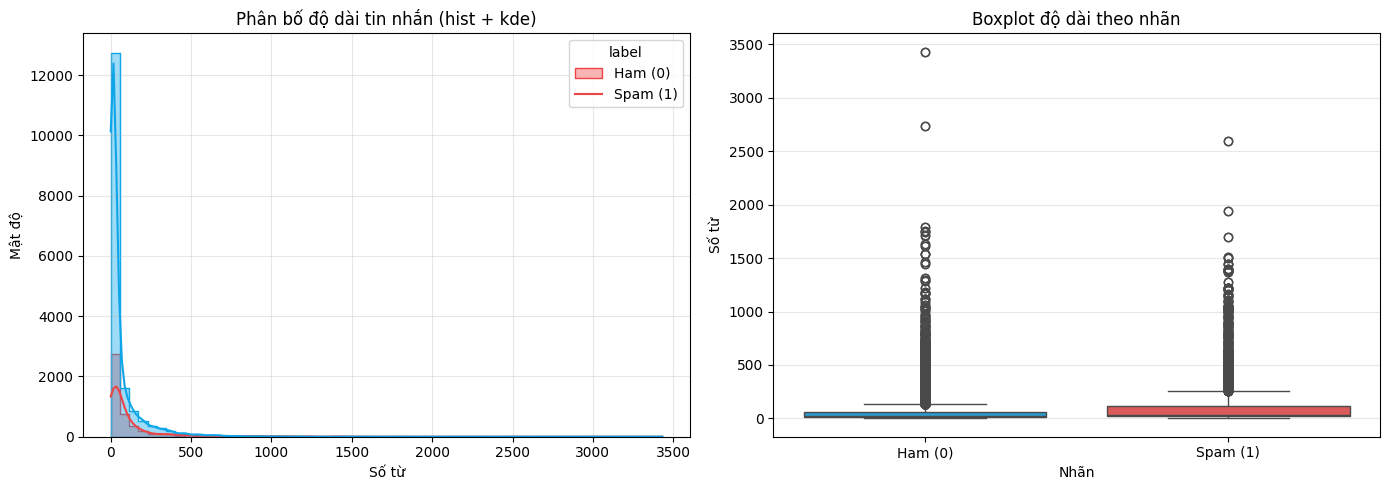

In [16]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo cột độ dài (số từ) nếu chưa có
if 'length' not in df.columns:
    df['length'] = df['clean_text'].apply(lambda s: len(str(s).split()))

# Palette hỗ trợ cả nhãn dạng số và chuỗi
palette_map = {0: '#0ea5e9', 1: '#ef4444', '0': '#0ea5e9', '1': '#ef4444'}

# Thứ tự nhãn nhất quán: 0 rồi 1 (dù là int hay string)
labels_unique = df['label'].unique()
try:
    order_vals = sorted(labels_unique, key=lambda v: int(v))
except Exception:
    order_vals = sorted(labels_unique)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram/KDE theo nhãn
sns.histplot(
    data=df, x='length', hue='label', hue_order=order_vals,
    bins=60, kde=True, palette=palette_map, element='step', alpha=0.4,
    ax=axes[0]
)
axes[0].set_title('Phân bố độ dài tin nhắn (hist + kde)')
axes[0].set_xlabel('Số từ'); axes[0].set_ylabel('Mật độ')
axes[0].legend(title='label', labels=['Ham (0)', 'Spam (1)'])
axes[0].grid(True, alpha=0.3)

# Boxplot theo nhãn
sns.boxplot(data=df, x='label', y='length', order=order_vals, palette=palette_map, ax=axes[1])
axes[1].set_title('Boxplot độ dài theo nhãn')
axes[1].set_xlabel('Nhãn'); axes[1].set_ylabel('Số từ')
# Đặt nhãn trục X khớp order
try:
    axes[1].set_xticklabels(['Ham (0)' if int(v) == 0 else 'Spam (1)' for v in order_vals])
except Exception:
    axes[1].set_xticklabels([str(v) for v in order_vals])
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


### Ma trận nhầm lẫn (Confusion Matrix)


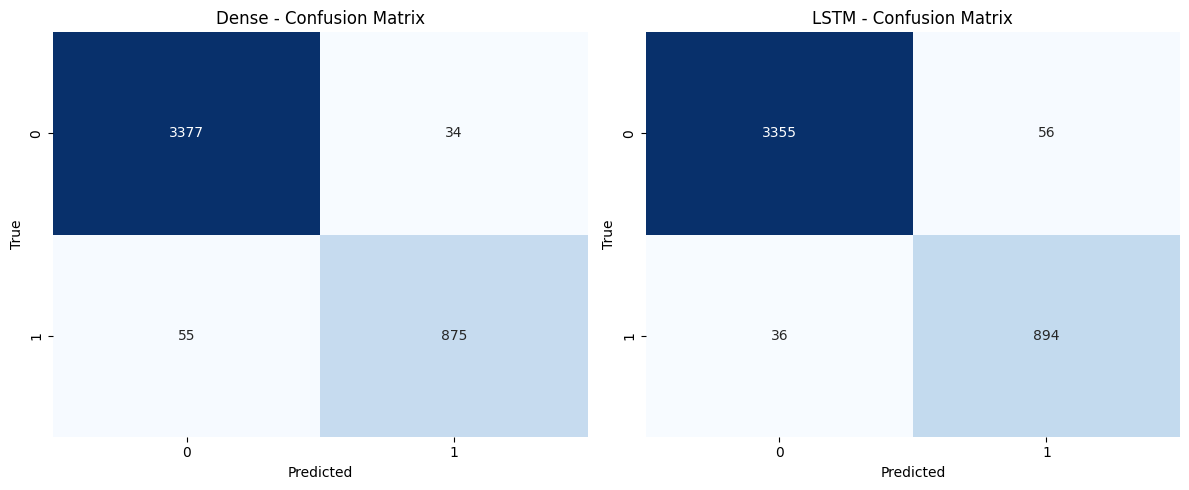

In [17]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Tính lại ma trận nhầm lẫn để vẽ (nếu cần)
cm_dense = confusion_matrix(y_test, y_pred_dense)
cm_lstm  = confusion_matrix(y_test, y_pred_lstm)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_dense, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_title('Dense - Confusion Matrix')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('True')

sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[1])
axes[1].set_title('LSTM - Confusion Matrix')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('True')

plt.tight_layout()
plt.show()


### ROC và Precision-Recall Curves


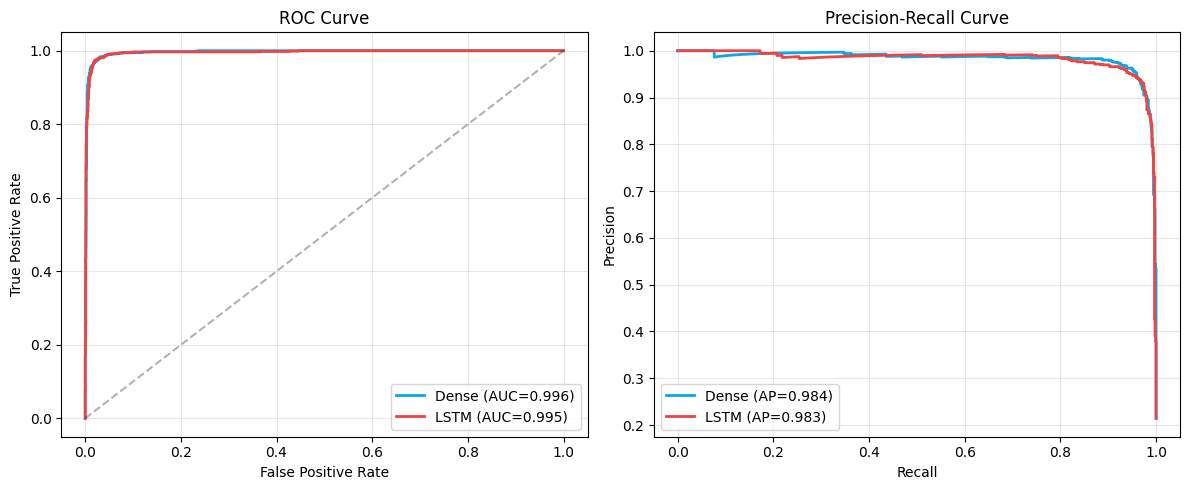

In [18]:
##############################
# Phạm Quang Minh - B22DCCN544
##############################
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Lấy xác suất dự đoán (đã có sẵn y_pred_prob_dense, y_pred_prob_lstm)
proba_dense = y_pred_prob_dense.ravel()
proba_lstm  = y_pred_prob_lstm.ravel()

# ROC
fpr_d, tpr_d, _ = roc_curve(y_test, proba_dense)
fpr_l, tpr_l, _ = roc_curve(y_test, proba_lstm)
auc_d = auc(fpr_d, tpr_d)
auc_l = auc(fpr_l, tpr_l)

# PR
prec_d, rec_d, _ = precision_recall_curve(y_test, proba_dense)
prec_l, rec_l, _ = precision_recall_curve(y_test, proba_lstm)
ap_d = average_precision_score(y_test, proba_dense)
ap_l = average_precision_score(y_test, proba_lstm)

plt.figure(figsize=(12, 5))

# ROC subplot
plt.subplot(1, 2, 1)
plt.plot(fpr_d, tpr_d, label=f'Dense (AUC={auc_d:.3f})', color='#0ea5e9', linewidth=2)
plt.plot(fpr_l, tpr_l, label=f'LSTM (AUC={auc_l:.3f})', color='#ef4444', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.legend(); plt.grid(True, alpha=0.3)

# PR subplot
plt.subplot(1, 2, 2)
plt.plot(rec_d, prec_d, label=f'Dense (AP={ap_d:.3f})', color='#0ea5e9', linewidth=2)
plt.plot(rec_l, prec_l, label=f'LSTM (AP={ap_l:.3f})', color='#ef4444', linewidth=2)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
